# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 장애/이상 예측 등에 필요
 
## 접근법
### 시계열 모델
- 자신의 과거 값만 사용하여 미래 값을 예측하는 방법
- 선형 예측(linear prediction), ARIMA 등 수리 모델 기반의 단변수 예측 모델이 널리 사용된다
 - 신호의 패턴에 따라 성능에 한계가 있다
 - 결측치가 없어야 한다 (결측치가 있으면 계산 오류 발생)
 - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
 - 선형 회귀 (linear regression) 모델: 자신의 과거 샘플의 가중합으로 미래를 예측하는 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 
 - ARIMA 모델: 선형 모델을 개선하여, 계절성, 트렌드, 시변성 등을 반영한 모델
 - 단변수 시계열 예측 도구로 Prophet이 편리하다 (이벤트 반영이 편리하며 결측치가 있어도 동작한다) 
 
 
### X-y 모델
- 다양한 관련 외부 신호들(X)을 모두 사용하여 y를 예측하는 모델
 - 입력 X에 y의 과거 값들도 포함시킬 수 있다
 - 입력 X에 변형된 신호들을 포함시킬 수 있다 (이동 평균 등)
 - 다양한 종류의 카테고리를 변수를 사용할 수 있다.
 - (계산 중심인 선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
- 랜덤 포레스트, 부스팅 등 머신러닝 모델을 사용한다.
 - 복잡한 현상을 모델링하기 위해 딥러닝 모델 (MLP, CNN, LSTM 등)을 사용하기도 한다
 

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

# 시계열 모델

- 전력 사용량 예측

## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 13})

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               

## 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [3]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [4]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test - y_pred, s=5)

# 에너지 사용 예측

## 데이터

- 한 가정의 3년간 시간 단위 에너지 사용 데이터를 이용

In [5]:
# power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
#                  parse_dates=['timestamp'])
power = pd.read_csv("./energy.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


In [6]:
# 단변수 예측
# df = power[['load', 'temp']]
df_power = power[:24*365].copy()
print(df_power.shape)
df_power[:3]

(8760, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 미래로 하나씩 이동하면서 데이터를 이용하는 예측을 walk forward 예측이라고 한다
- 시계열 데이터를 테이블 구조로 만들기
 - 시계열 예측에 머신러닝 모델을 쉽게 적용하기 위해서 비정형인 시계열 데이터를 정형 데이터인 테이블 구조로 만들어야 한다
 - 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

# shift를 이용한 특성 추가

In [7]:
df = df_power.copy()

In [8]:
df["load-1"] = df["load"].shift(1)
df[:3]

,load,temp,load-1
timestamp,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN
2012-01-01 01:00:00,2558.0,32.666667,2698.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0


In [9]:
# 임의의 컬럼을 아래로 shift(n_shift) 수행하는 함수
def add_shifts(df_input, **cols):
    df = df_input.copy()
    for col, n_shift in cols.items():
        for i in range (1, n_shift+1):
            df[col+'-'+str(i)]=df[col].shift(i)
    return df

In [10]:
cols = {'load':3}
df_sh = add_shifts(df, **cols)
df_sh

,load,temp,load-1,load-2,load-3
timestamp,,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,NaN,NaN
2012-01-01 01:00:00,2558.0,32.666667,2698.0,NaN,NaN
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2698.0,NaN
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2558.0,2698.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2444.0,2558.0
...,...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,4304.0,4065.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,4253.0,4304.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,4119.0,4253.0


In [11]:
# 예측할 목적 변수 설정: 특정 컬럼을 위로 한 행씩 이동
df["load+1"] = df["load"].shift(-1)
df

,load,temp,load-1,load+1
timestamp,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,2558.0
2012-01-01 01:00:00,2558.0,32.666667,2698.0,2444.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2402.0
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2403.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2453.0
...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,3977.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,3736.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,3444.0


In [12]:
# 컬럼 y 를 future에서 지정한 수 만큼 위로 이동하는 함수
def add_y_values(df_input, y, *future):
    df = df_input.copy()
    for i in future:
        df[y+'+'+str(i)]=df[y].shift(-i)
    return df

In [13]:
future = list(range(1,3))
df_sh = add_y_values(df, 'load',*future)
df_sh

,load,temp,load-1,load+1,load+2
timestamp,,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,2558.0,2444.0
2012-01-01 01:00:00,2558.0,32.666667,2698.0,2444.0,2402.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2402.0,2403.0
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2403.0,2453.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2453.0,2560.0
...,...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,3977.0,3736.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,3736.0,3444.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,3444.0,3178.0


## X, y 테이블 만들기

In [15]:
def get_table_multi_shifts(df, y, *future, **cols):
    df1 = add_shifts(df, **cols)
    df2 = add_y_values(df1, y, *future)
    return df2

In [16]:
df = df_power.copy()

cols = {'load':4}
future = [1]
df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
print(df_sh.shape)
df = df_sh.dropna()
print(df.shape)

(8760, 7)
(8755, 7)


In [17]:
df

,load,temp,load-1,load-2,load-3,load-4,load+1
timestamp,,,,,,,
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2444.0,2558.0,2698.0,2453.0
2012-01-01 05:00:00,2453.0,31.333333,2403.0,2402.0,2444.0,2558.0,2560.0
2012-01-01 06:00:00,2560.0,30.000000,2453.0,2403.0,2402.0,2444.0,2719.0
2012-01-01 07:00:00,2719.0,29.000000,2560.0,2453.0,2403.0,2402.0,2916.0
2012-01-01 08:00:00,2916.0,29.000000,2719.0,2560.0,2453.0,2403.0,3105.0
...,...,...,...,...,...,...,...
2012-12-30 18:00:00,4253.0,18.333333,4304.0,4065.0,3715.0,3684.0,4119.0
2012-12-30 19:00:00,4119.0,17.666667,4253.0,4304.0,4065.0,3715.0,3977.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,4253.0,4304.0,4065.0,3736.0


In [18]:
X = df[df.columns.difference(['temp', 'load+1'])]
y = df['load+1'].values

In [19]:
X[:3]

,load,load-1,load-2,load-3,load-4
timestamp,,,,,
2012-01-01 04:00:00,2403.0,2402.0,2444.0,2558.0,2698.0
2012-01-01 05:00:00,2453.0,2403.0,2402.0,2444.0,2558.0
2012-01-01 06:00:00,2560.0,2453.0,2403.0,2402.0,2444.0


# 선형 예측 모델

## 최적의 윈도우 크기 찾기

In [40]:
lr= LinearRegression()
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor()

In [21]:
def model_run(model, X, y, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=shuffle, random_state=9)
    model.fit(X_train, y_train) 
    return model.score(X_test, y_test).round(4)

In [22]:
model = lr
result = []
for window_size in range(1,100,2):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

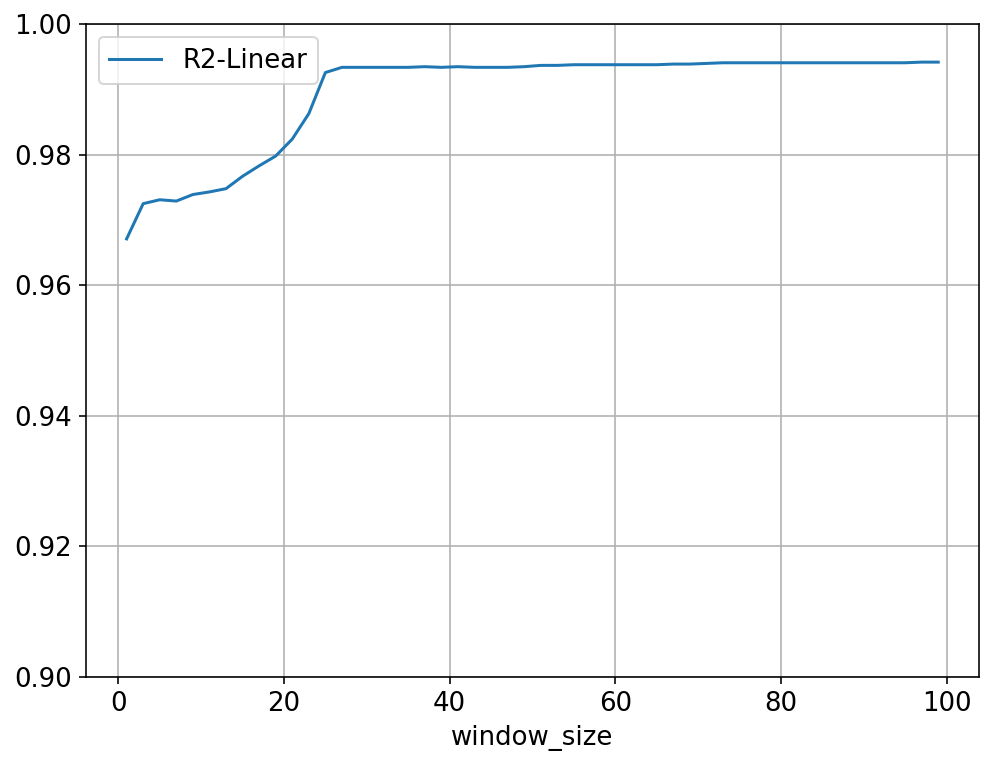

In [32]:
df_result = pd.DataFrame(result, columns=['window_size','R2-Linear'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.9,1])
plt.grid(axis = 'both')

In [33]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

KeyError: 'R2'

## LightGBM

In [25]:
result2 = []
model = lgbm_r
for window_size in range(1,100,2):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result2.append((window_size, score))

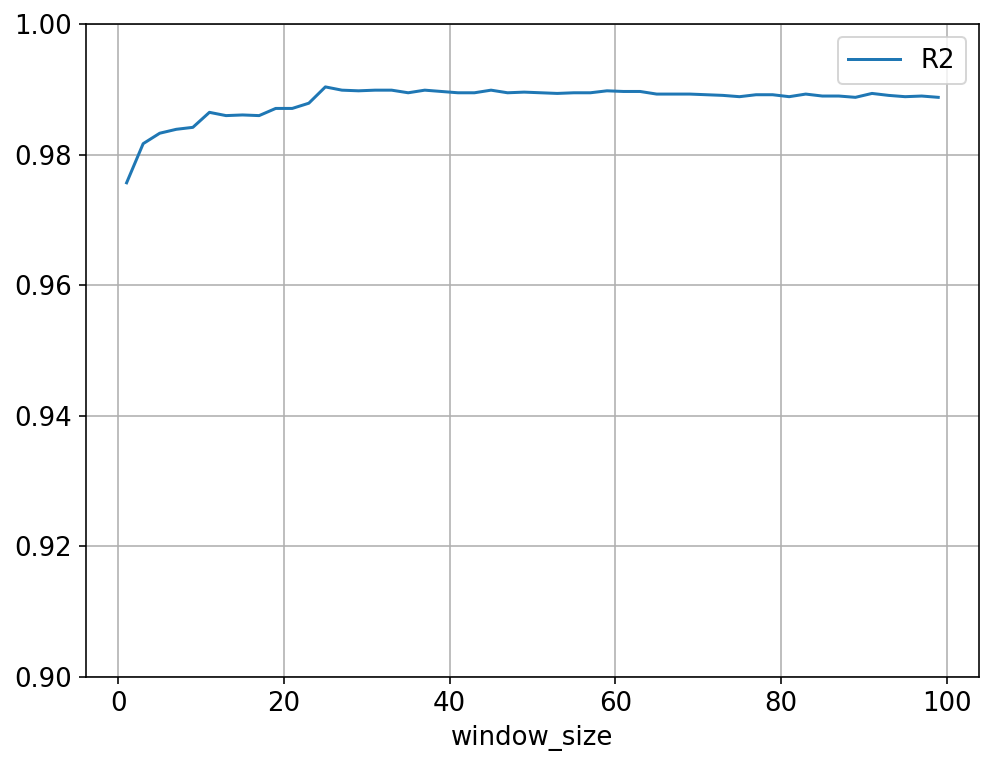

In [26]:
df_result2 = pd.DataFrame(result2, columns=['window_size','R2'])
df_result2.set_index('window_size', drop=True).plot(ylim=[0.9,1])
plt.grid(axis = 'both')

In [27]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(97, 0.9942)

In [35]:
df_result['R2_LGBM'] = df_result2["R2"]
df_result[:3]

,window_size,R2-Linear,R2_LGBM
0,1,0.9671,0.9757
1,3,0.9725,0.9817
2,5,0.9731,0.9833


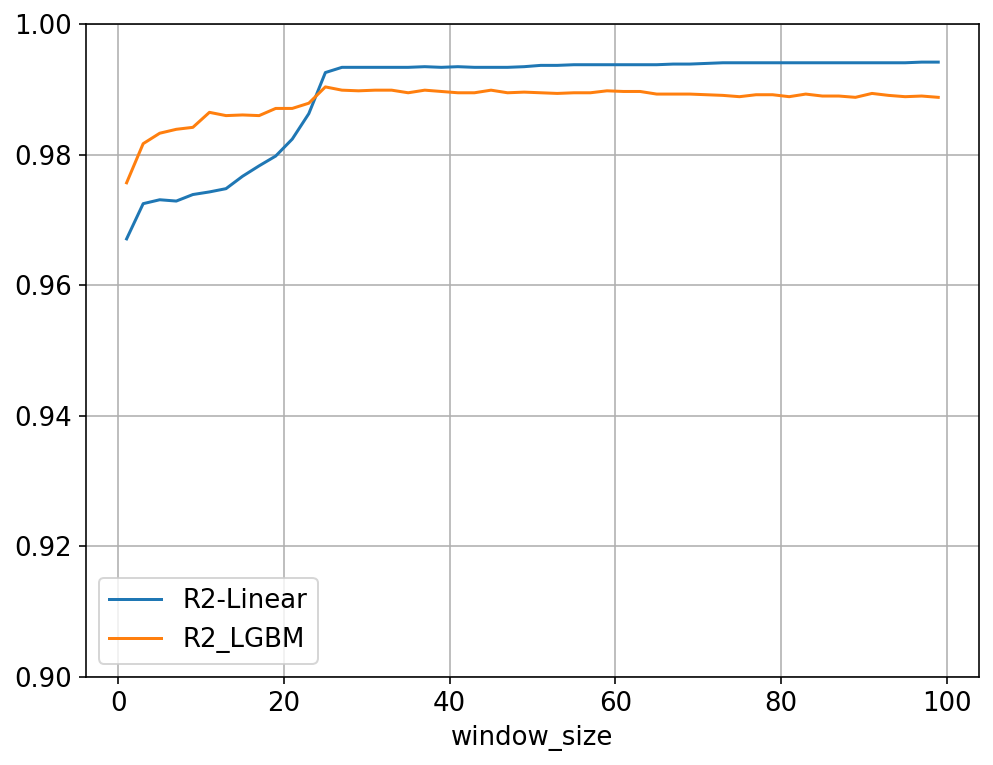

In [36]:
df_result.set_index('window_size', drop=True).plot(ylim=[0.9,1])
plt.grid(axis = 'both')

## 먼 미래 예측
- 윈도우 크기는 25로 고정
- 미래 24시간 후까지 예측하는 성능을 비교

In [52]:
window_size = 25
max_steps = 24
result = []
for model in [lr, lgbm_r]:
    for step in range(1,max_steps+1):
        df = df_power.copy()
        cols = {'load': window_size}
        future = [step]
        df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
        df_sh = df_sh.dropna()
        X = df_sh[df_sh.columns.difference(['temp', 'load+'+str(step)])]
        y = df_sh['load+'+str(step)].values
        score = model_run(model, X, y, shuffle=False)
        result.append((model,step, score))

In [53]:
df_r = pd.DataFrame(result, columns=['model','steps','R2'])
df_r[:3]

,model,steps,R2
0,LinearRegression(),1,0.9926
1,LinearRegression(),2,0.9703
2,LinearRegression(),3,0.9465


In [54]:
df_r['model'] = max_steps*['Linear']+max_steps*['LGBM']
df_r[:10]

,model,steps,R2
0,Linear,1,0.9926
1,Linear,2,0.9703
2,Linear,3,0.9465
3,Linear,4,0.9277
4,Linear,5,0.9130
5,Linear,6,0.9015
6,Linear,7,0.8923
7,Linear,8,0.8859
8,Linear,9,0.8822
9,Linear,10,0.8814


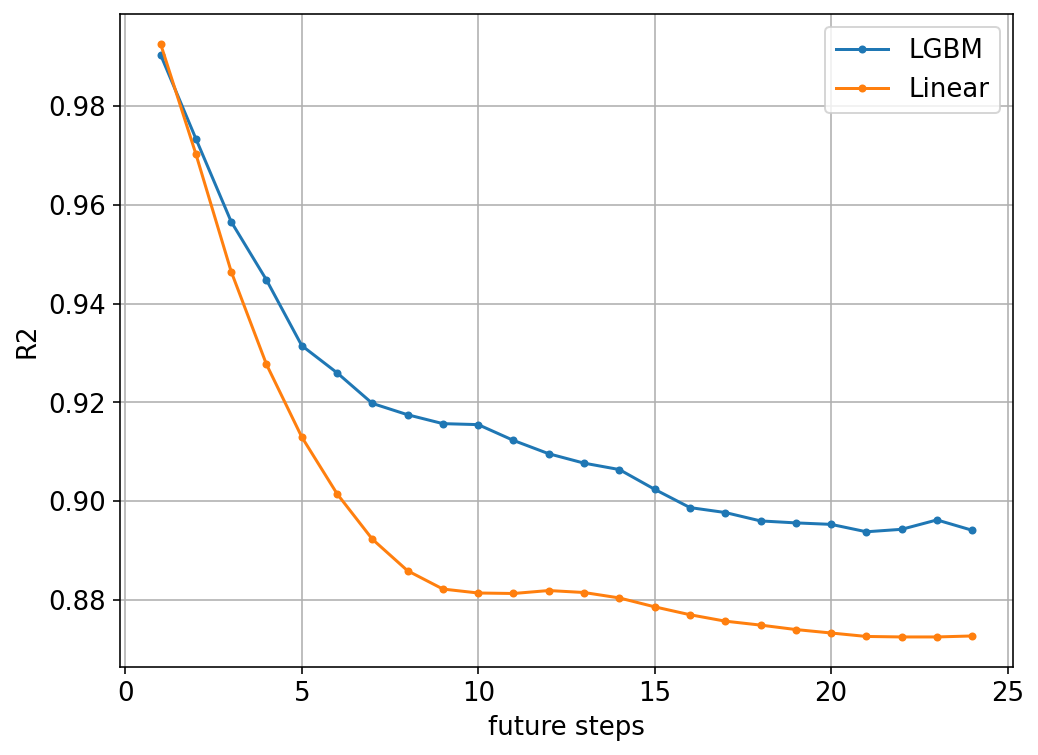

In [58]:
for model, group in df_r.groupby('model'):
    plt.plot(group['steps'], group['R2'], 
             marker='.', label=model)
plt.legend()
plt.xlabel('future steps')
plt.ylabel('R2')
plt.grid(axis = 'both')

# 다중변수 예측

- 자신의 과거 값과 다른 특성을 같이 사용하는 방법
- 예) 자신의 과거 전력사용량 25개 샘플과 12 시간의 날씨를 입력으로 사용하는 경우

# 다중 출력 예측

- 향후 6시간의 전력 사용량 예측

In [59]:
df = df_power.copy()

cols = {'load':25, 'temp':12}
future = list(range(1,7))
df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
print(df_sh.shape)
df = df_sh.dropna()
print(df.shape)

(8760, 45)
(8729, 45)


In [60]:
df[:3].T

timestamp,2012-01-02 01:00:00,2012-01-02 02:00:00,2012-01-02 03:00:00
load,2354.000000,2294.000000,2288.000000
temp,43.000000,42.666667,43.666667
load-1,2458.000000,2354.000000,2294.000000
load-2,2639.000000,2458.000000,2354.000000
load-3,2873.000000,2639.000000,2458.000000
load-4,3129.000000,2873.000000,2639.000000
load-5,3344.000000,3129.000000,2873.000000
load-6,3513.000000,3344.000000,3129.000000
load-7,3659.000000,3513.000000,3344.000000
load-8,3717.000000,3659.000000,3513.000000


In [61]:
targets = ['load+'+str(i) for i in range(1,7)]
print(targets)

['load+1', 'load+2', 'load+3', 'load+4', 'load+5', 'load+6']


In [62]:
features = df.columns.difference(targets)
features[:10]

Index(['load', 'load-1', 'load-10', 'load-11', 'load-12', 'load-13', 'load-14',
       'load-15', 'load-16', 'load-17'],
      dtype='object')

In [63]:
X = df[features]

### 선형, 랜덤포레스트, 부스팅 비교

In [64]:
result3 = []
for model in [lr, rfr, lgbm_r]:
    for i in range(1,7):
        y = df['load+'+str(i)]
        r2 = model_run(model, X, y, shuffle=False)
        result3.append((model, i, r2))

In [65]:
df_r = pd.DataFrame(result3, columns=['model','steps','r2'])
models = 6*['Linear']+6*['RandomForest']+6*['LGBM']
df_r['model'] = models
df_r[:10]

,model,steps,r2
0,Linear,1,0.9926
1,Linear,2,0.9704
2,Linear,3,0.9468
3,Linear,4,0.9285
4,Linear,5,0.9143
5,Linear,6,0.9033
6,RandomForest,1,0.9881
7,RandomForest,2,0.9652
8,RandomForest,3,0.9481
9,RandomForest,4,0.9352


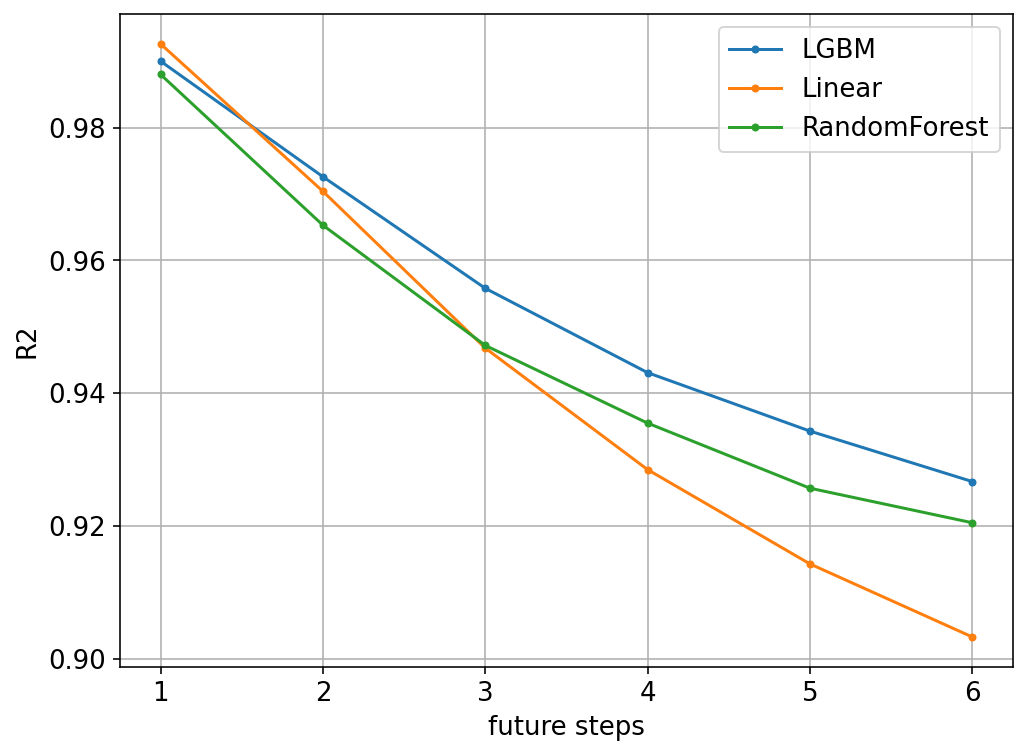

In [74]:
for model, group in df_r.groupby('model'):
    plt.plot(group['steps'], group['r2'], 
             marker='.', label=model)
plt.legend()
plt.xlabel('future steps')
plt.ylabel('R2')
plt.grid(axis = 'both')

## 랜덤 포레스트 다중 예측
- 랜덤 포레스트는 한번에 여러개의 y 값을 예측하는 모델을 지원한다
- 아래는 y에 6개의 값을 한번에 예측하도록 했다

In [67]:
y = df[targets]
y[:3]

,load+1,load+2,load+3,load+4,load+5,load+6
timestamp,,,,,,
2012-01-02 01:00:00,2294.0,2288.0,2353.0,2503.0,2737.0,2960.0
2012-01-02 02:00:00,2288.0,2353.0,2503.0,2737.0,2960.0,3185.0
2012-01-02 03:00:00,2353.0,2503.0,2737.0,2960.0,3185.0,3390.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        shuffle=False, random_state=9)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred, multioutput='raw_values')

array([0.98044884, 0.96204043, 0.94938743, 0.94075121, 0.93268136,
       0.92626317])

# 기타 특성 추가
- 이동평균, 이동분산, 최대-최소 차이, 평활화(ewma: Exponentially-weighted moving average) 등 특성을 추가할 수 있다
- 특성 추가 방법은 다른 예제 참조

In [69]:
# 과거 5일간의 평균치를 컬럼에 추가
X2= X.copy()
X2["5-mean"] = X2.load.rolling(5,min_periods=1).mean()
X2[:3].T

timestamp,2012-01-02 01:00:00,2012-01-02 02:00:00,2012-01-02 03:00:00
load,2354.000000,2294.000000,2288.000000
load-1,2458.000000,2354.000000,2294.000000
load-10,3137.000000,3486.000000,3717.000000
load-11,3122.000000,3137.000000,3486.000000
load-12,3147.000000,3122.000000,3137.000000
load-13,3184.000000,3147.000000,3122.000000
load-14,3180.000000,3184.000000,3147.000000
load-15,3174.000000,3180.000000,3184.000000
load-16,3105.000000,3174.000000,3180.000000
load-17,2916.000000,3105.000000,3174.000000


- 다양한 특성 추가 예시
- ema에 지수형 가중값을 구한다
- min_periods=1 의 의미는 필요한 갯수가 되지 않더라도, 한개라도 평균 등을 계산하라는 뜻임 (초기 값들을 버리지 않기 위함)

In [70]:
X2["20-mean"] = X2.load.rolling(20,min_periods=1).mean()
X2["10-std"] = X2.load.rolling(10, min_periods=1).std().fillna(0)
X2['5EWMA'] = X2.load.ewm(span=5).mean()
X2["5-max"] = X2.load.rolling(5, min_periods=1).max()
X2["5-min"] = X2.load.rolling(5, min_periods=1).min()
X2["5-peak-difference"] = X2.load.rolling(5, min_periods=1).max()-X2.load.rolling(5, min_periods=1).min()
X2[:3]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-16,load-17,...,temp-7,temp-8,temp-9,5-mean,20-mean,10-std,5EWMA,5-max,5-min,5-peak-difference
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-02 01:00:00,2354.0,2458.0,3137.0,3122.0,3147.0,3184.0,3180.0,3174.0,3105.0,2916.0,...,41.333333,41.666667,43.333333,2354.0,2354.0,0.000000,2354.000000,2354.0,2354.0,0.0
2012-01-02 02:00:00,2294.0,2354.0,3486.0,3137.0,3122.0,3147.0,3184.0,3180.0,3174.0,3105.0,...,41.666667,41.333333,41.666667,2324.0,2324.0,42.426407,2318.000000,2354.0,2294.0,60.0
2012-01-02 03:00:00,2288.0,2294.0,3717.0,3486.0,3137.0,3122.0,3147.0,3184.0,3180.0,3174.0,...,42.666667,41.666667,41.333333,2312.0,2312.0,36.496575,2303.789474,2354.0,2288.0,66.0


In [81]:
# X2를 사용하는 경우의 성능 비교 (아래에서 X2를 사용함)
result4 = []
for model in [lr, rfr, lgbm_r]:
    for i in range(1,7):
        y = df['load+'+str(i)]
        r2 = model_run(model, X2, y, shuffle=False)
        result4.append((model, i, r2))

In [83]:
df_r = pd.DataFrame(result4, columns=['model','steps','r2'])
models = 6*['Linear']+6*['RandomForest']+6*['LGBM']
df_r['model'] = models

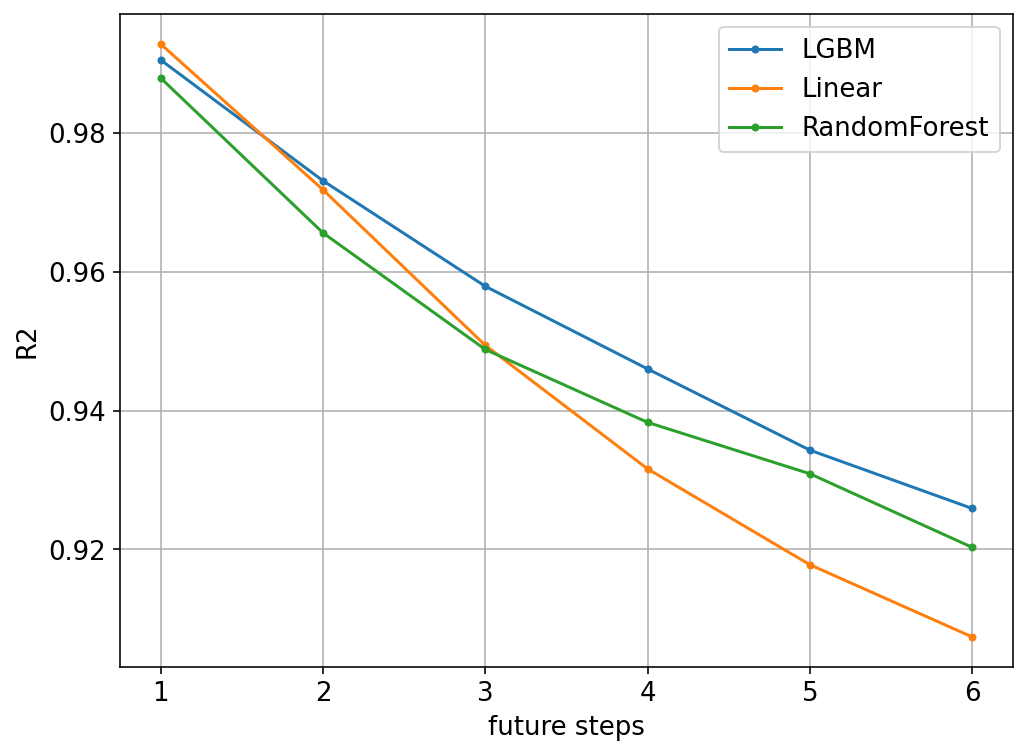

In [84]:
for model, group in df_r.groupby('model'):
    plt.plot(group['steps'], group['r2'], 
             marker='.', label=model)
plt.legend()
plt.xlabel('future steps')
plt.ylabel('R2')
plt.grid(axis = 'both')

# 정답